In [113]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools_open as tools
import seaborn as sns
from scipy.stats import truncnorm



In [114]:
# Configuration
NUM_RIDES = 1_000_000
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 12, 31, 23, 59)

BASE_DURATION_KM_CITY = 2
BASE_DURATION_KM_AIRPORT = 1.3

In [115]:
# Barcelona taxi tariff constants
BASE_FARE = 2.75              # Fixed base fare
PRICE_PER_KM_DAY = 1.32       # Price per km (daytime 08:00 - 20:00)
PRICE_PER_KM_NIGHT = 1.62     # Price per km (nighttime 20:00 - 08:00)
AIRPORT_SURCHARGE = 4.50      # Fixed
HOLIDAY_SURCHARGE = 3.50      # Fixed
PASSENGERS_SURCHARGE = 4.50   # Passenger count more than 4 (from 5-8)
MIN_FARE = 7                  # Minimum total
MIN_FARE_AIRPORT = 21         # Minimum airport ride


# Simulated holidays (partial list for 2024 in Barcelona)
HOLIDAYS = [
    "2024-01-01", "2024-01-06", "2024-04-01", "2024-05-01", "2024-06-24",
    "2024-08-15", "2024-09-11", "2024-10-12", "2024-11-01", "2024-12-06", "2024-12-25"
]
HOLIDAYS = set(pd.to_datetime(HOLIDAYS).date)

In [116]:
def generate_pickup_times(num_samples):
    base = pd.date_range(start="2024-01-01", end="2024-12-31 23:59", freq="min")
    weights = []

    # Base weekday multipliers
    weekday_weights = {
        0: 0.5,   # Monday
        1: 1.0,   # Tuesday
        2: 0.95,  # Wednesday
        3: 1.05,  # Thursday
        4: 1.2,   # Friday
        5: 1.3,   # Saturday
        6: 1.2    # Sunday
    }

    def get_seasonal_weight(month, hour):
        weight = 1.6
        if month in [6, 7, 8]:  # Summer
            if 10 <= hour < 17:
                return weight * 1.3
            elif 20 <= hour < 24:
                return weight * 1.4
            elif 0 <= hour < 3:
                return weight * 1.2
            return weight
        elif month in [5, 9]:  # Shoulder season
            return 1.4
        return 1.0

    def get_hourly_weight(hour):
        if 7 <= hour < 10 or 17 <= hour < 20:
            return 1.5
        elif 0 <= hour < 6:
            return 0.5
        elif 20 <= hour < 23:
            return 0.8
        return 1.0

    def get_special_event_weight(weekday, hour):
        if weekday == 5 and hour >= 20:  # Saturday night
            return 1.55
        elif weekday == 6 and hour < 6:  # Early Sunday
            return 1.55
        elif weekday == 4 and hour >= 20:  # Friday night
            return 1.3
        return 1.0

    for t in base:
        weekday = t.weekday()
        hour = t.hour
        month = t.month

        weight = 1.0
        weight *= weekday_weights[weekday]
        weight *= get_seasonal_weight(month, hour)
        weight *= get_hourly_weight(hour)
        weight *= get_special_event_weight(weekday, hour)
        weight *= np.random.normal(1.0, 0.05)  # Final light global noise

        weights.append(weight)

    weights = np.array(weights)
    weights /= weights.sum()
    sampled_times = np.random.choice(base, size=num_samples, replace=True, p=weights)
    return pd.to_datetime(sampled_times)

In [117]:
# Adding traffic noise based on time of day
def get_traffic_noise(hour):
    if 7 <= hour < 10 or 17 <= hour < 20:  # Peak hours
        return np.random.normal(1.3, 0.05)
    elif 10 <= hour < 17:  # Midday (moderate congestion)
        return np.random.normal(1.2, 0.05)
    elif 20 <= hour < 23:  # Evening (pre-nightlife)
        return np.random.normal(1.1, 0.05)
    elif 0 <= hour < 6:  # Late night (low traffic)
        return np.random.normal(0.9, 0.05)
    else:  # Early morning, post-rush
        return np.random.normal(1.0, 0.05)


# Generate passenger count (1 to 8 passengers)
def generate_passenger_count():
    """Randomly assign passenger count between 1 and 8."""
    return np.random.randint(1, 9)


# Improved airport ride probability (20% chance for airport ride)
def is_airport_ride():
    """Return True if the ride is an airport ride (20% chance)."""
    return np.random.rand() < 0.20

# Improved distance generator function based on airport and non-airport rides
# def generate_distance(is_airport):
#     if is_airport:
#         return np.random.uniform(15, 30)  # Realistic airport range
#     else:
#         return np.clip(np.random.exponential(scale=8), 3, 40)  # Updated mean



In [118]:
def truncated_normal(mean=22, std=3, low=15, high=30):
    """Generate one value from a truncated normal distribution."""
    a, b = (low - mean) / std, (high - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)


def truncated_exponential(scale=8, low=3, high=40):
    while True:
        value = np.random.exponential(scale=scale)
        if low <= value <= high:
            return value


def generate_distance(is_airport):
    if is_airport:
        return truncated_normal(mean=22, std=3, low=15, high=30)
    else:
        return truncated_exponential(scale=8, low=3, high=40)

In [119]:
# Compose DataFrame
df = pd.DataFrame({
    "pickup_datetime": generate_pickup_times(NUM_RIDES)
})

# Generate airport ride flags first
df["is_airport_ride"] = [is_airport_ride() for _ in range(NUM_RIDES)]

# distances are capped between 3-40 km
df["distance_km"] = df["is_airport_ride"].apply(generate_distance)
df["duration_min"] = df.apply(
    lambda x: x["distance_km"] * (BASE_DURATION_KM_AIRPORT if x["is_airport_ride"] else BASE_DURATION_KM_CITY),
    axis=1
)

# Apply traffic noise AFTER base duration is computed
df["traffic_noise"] = df["pickup_datetime"].dt.hour.apply(get_traffic_noise)
df["duration_min"] *= df["traffic_noise"]
df["duration_min"] = np.clip(df["duration_min"], 5, 80)

# Now dropoff time is computed using the final noisy duration
df["dropoff_datetime"] = df["pickup_datetime"] + pd.to_timedelta(df["duration_min"], unit='m')

# Add time-based features
df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["month"] = df["pickup_datetime"].dt.month
df["is_weekend"] = df["day_of_week"] >= 5
df["is_night"] = (df["hour"] < 8) | (df["hour"] >= 20)
df["is_holiday"] = df["pickup_datetime"].dt.date.isin(HOLIDAYS)

# Passenger count
df["passenger_count"] = [generate_passenger_count() for _ in range(NUM_RIDES)]

In [120]:
# Fare calculation
def calculate_fare(row):
    fare = BASE_FARE
    fare += row["distance_km"] * (PRICE_PER_KM_NIGHT if row["is_night"] else PRICE_PER_KM_DAY)
    #fare += row["duration_min"] * PRICE_PER_MIN
    if row["is_holiday"]:
        fare += HOLIDAY_SURCHARGE
    if row["is_airport_ride"]:
        fare += AIRPORT_SURCHARGE
   
    if row["passenger_count"] > 4:
        fare += PASSENGERS_SURCHARGE
        
    if row["is_airport_ride"] and fare < MIN_FARE_AIRPORT:
        fare = MIN_FARE_AIRPORT
    elif fare < MIN_FARE:
        fare = MIN_FARE
    return round(fare, 2)

In [121]:
df["fare_amount"] = df.apply(calculate_fare, axis=1)

In [122]:
tools.display_dataframe_to_user(name="Synthetic Taxi Ride Data", dataframe=df.head(50))

Synthetic Taxi Ride Data


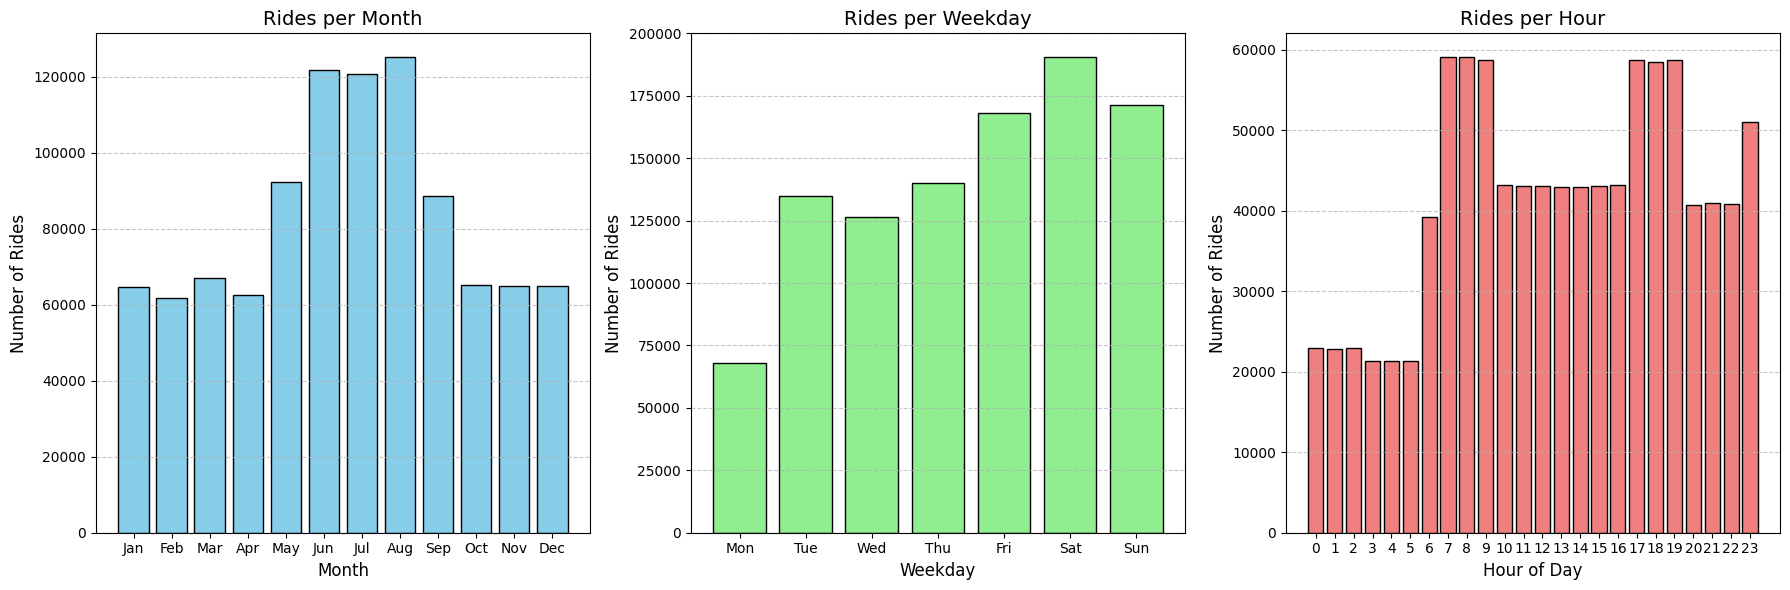

In [123]:
# Count rows per month, weekday, and hour
monthly_counts = df["month"].value_counts().sort_index()
weekday_counts = df["day_of_week"].value_counts().sort_index()
hourly_counts = df["hour"].value_counts().sort_index()

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for months
axes[0].bar(monthly_counts.index, monthly_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Rides per Month', fontsize=14)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Rides', fontsize=12)
axes[0].set_xticks(range(1, 13))  # Months from 1 to 12
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for weekdays
axes[1].bar(weekday_counts.index, weekday_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('Rides per Weekday', fontsize=14)
axes[1].set_xlabel('Weekday', fontsize=12)
axes[1].set_ylabel('Number of Rides', fontsize=12)
axes[1].set_xticks(range(7))  # Weekdays from 0 (Monday) to 6 (Sunday)
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for hours
axes[2].bar(hourly_counts.index, hourly_counts.values, color='lightcoral', edgecolor='black')
axes[2].set_title('Rides per Hour', fontsize=14)
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_ylabel('Number of Rides', fontsize=12)
axes[2].set_xticks(range(0, 24))  # Hours from 0 to 23
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

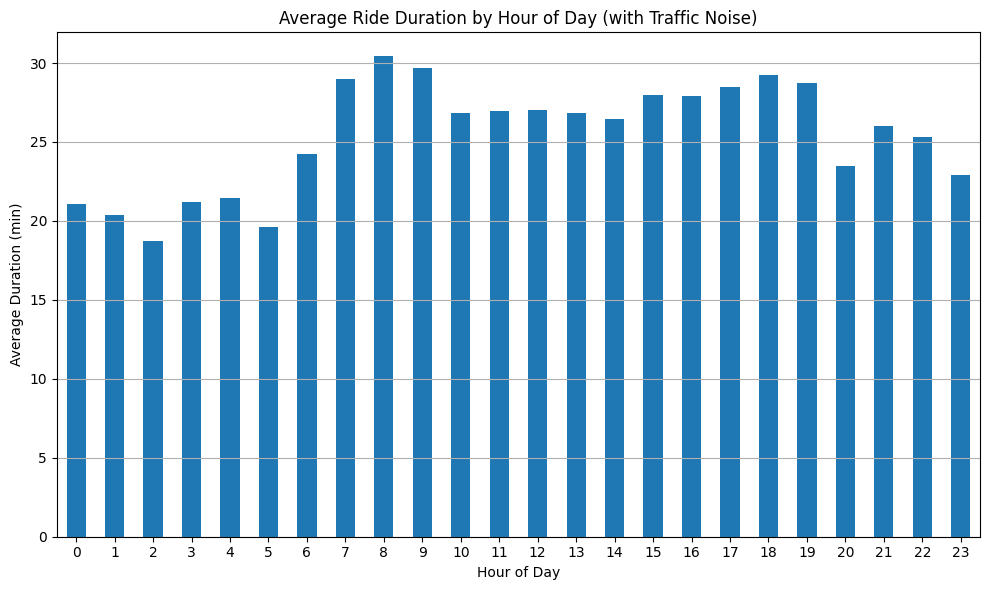

In [124]:
# We'll use a smaller sample to make plotting manageable
sample_df = df.sample(10000)

# Plot average duration by hour of day
avg_duration_by_hour = sample_df.groupby("hour")["duration_min"].mean()

plt.figure(figsize=(10, 6))
avg_duration_by_hour.plot(kind="bar")
plt.title("Average Ride Duration by Hour of Day (with Traffic Noise)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration (min)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipykernel_9586/3670702328.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


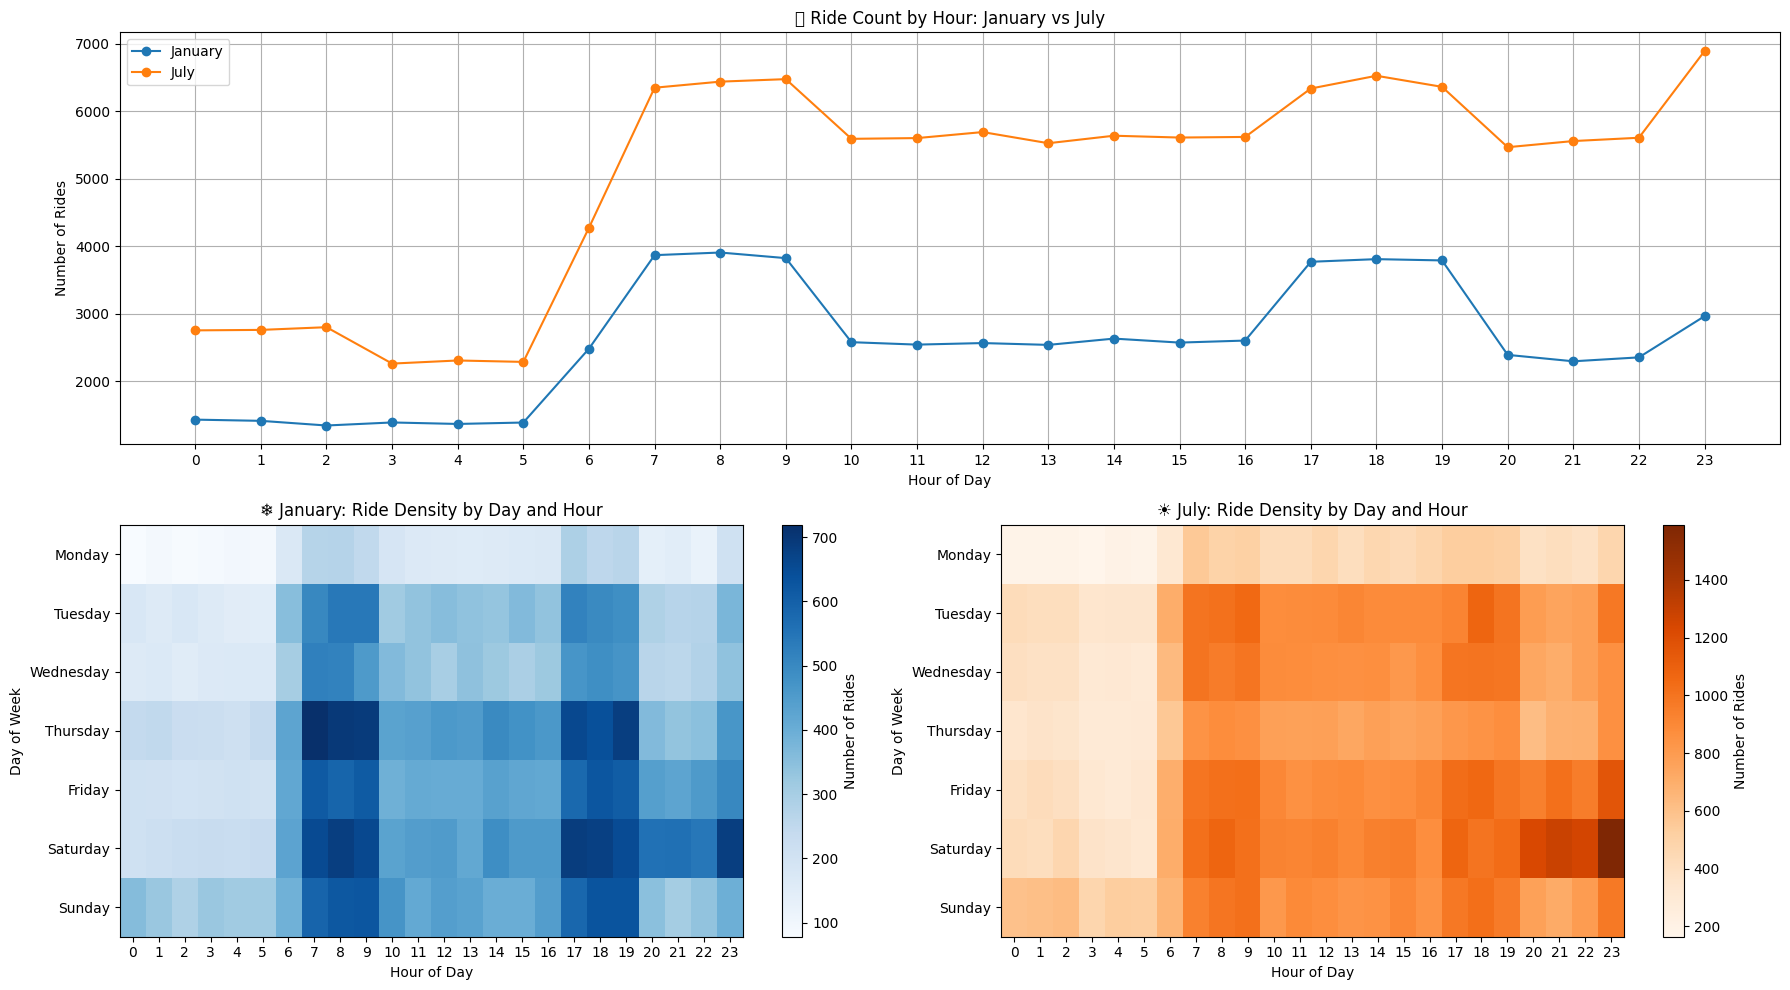

In [125]:
import matplotlib.gridspec as gridspec

df_copy = df.copy()

df_copy["weekday"] = df_copy["pickup_datetime"].dt.day_name()
df_copy["month_name"] = df_copy["pickup_datetime"].dt.month_name()

# Filter for January and July
df_jan = df_copy[df_copy["month"] == 2]
df_jul = df_copy[df_copy["month"] == 7]


fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

# Plot 1: Ride count by hour (spans entire first row)
jan_hourly = df_jan["hour"].value_counts().sort_index()
jul_hourly = df_jul["hour"].value_counts().sort_index()

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(jan_hourly.index, jan_hourly.values, label="January", marker='o')
ax1.plot(jul_hourly.index, jul_hourly.values, label="July", marker='o')
ax1.set_title("📊 Ride Count by Hour: January vs July")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Number of Rides")
ax1.set_xticks(np.arange(24))
ax1.grid(True)
ax1.legend()

# Plot 2: Heatmap for January (bottom-left)
jan_pivot = df_jan.groupby(["weekday", "hour"]).size().unstack(fill_value=0)
jan_pivot = jan_pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax2 = fig.add_subplot(gs[1, 0])
im1 = ax2.imshow(jan_pivot, aspect='auto', cmap="Blues")
fig.colorbar(im1, ax=ax2, label="Number of Rides")
ax2.set_xticks(np.arange(24))
ax2.set_yticks(np.arange(7))
ax2.set_yticklabels(jan_pivot.index)
ax2.set_title("❄️ January: Ride Density by Day and Hour")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Day of Week")

# Plot 3: Heatmap for July (bottom-right)
jul_pivot = df_jul.groupby(["weekday", "hour"]).size().unstack(fill_value=0)
jul_pivot = jul_pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax3 = fig.add_subplot(gs[1, 1])
im2 = ax3.imshow(jul_pivot, aspect='auto', cmap="Oranges")
fig.colorbar(im2, ax=ax3, label="Number of Rides")
ax3.set_xticks(np.arange(24))
ax3.set_yticks(np.arange(7))
ax3.set_yticklabels(jul_pivot.index)
ax3.set_title("☀️ July: Ride Density by Day and Hour")
ax3.set_xlabel("Hour of Day")
ax3.set_ylabel("Day of Week")

plt.tight_layout()
plt.show()

/tmp/ipykernel_9586/448060714.py:15: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


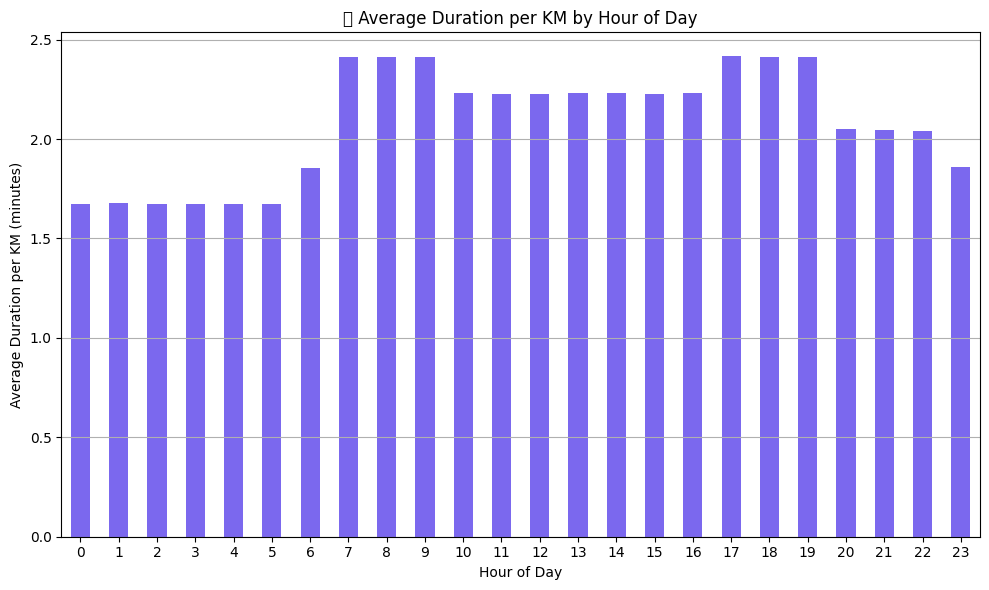

In [126]:
# Use df_ml to calculate duration per km and average by hour
df_copy["duration_per_km"] = df_copy["duration_min"] / df_copy["distance_km"]

# Group by hour and calculate average duration per km
avg_duration_per_km_by_hour = df_copy.groupby("hour")["duration_per_km"].mean()

# Plot the result
plt.figure(figsize=(10, 6))
avg_duration_per_km_by_hour.plot(kind="bar", color="mediumslateblue")
plt.title("🕒 Average Duration per KM by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration per KM (minutes)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipykernel_9586/3243076568.py:26: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


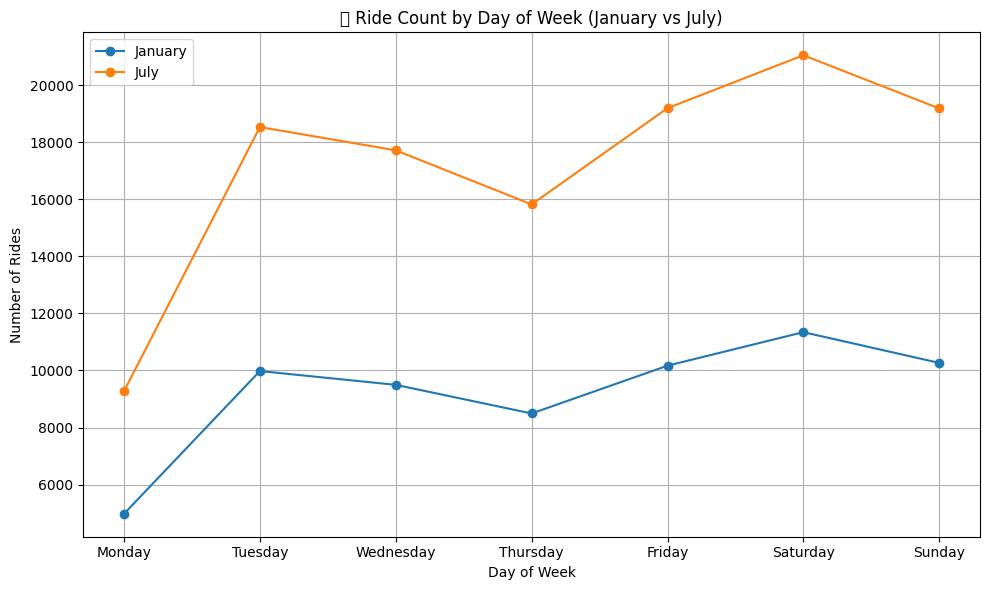

In [127]:
# Add weekday names for grouping
df_copy["weekday"] = df_copy["pickup_datetime"].dt.day_name()

# Extract January and July again
df_jan_cleaned = df_copy[df_copy["month"] == 1]
df_jul_cleaned = df_copy[df_copy["month"] == 7]

# Count rides per weekday for each
jan_weekday_counts = df_jan_cleaned["weekday"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

jul_weekday_counts = df_jul_cleaned["weekday"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(jan_weekday_counts.index, jan_weekday_counts.values, label="January", marker='o')
plt.plot(jul_weekday_counts.index, jul_weekday_counts.values, label="July", marker='o')
plt.title("📅 Ride Count by Day of Week (January vs July)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [128]:
# View a sample
print("\nSample rows:")
display(df.head())

# Summary statistics
print("\nSummary statistics:")
display(df.describe())


Sample rows:


,pickup_datetime,is_airport_ride,distance_km,duration_min,traffic_noise,dropoff_datetime,hour,day_of_week,month,is_weekend,is_night,is_holiday,passenger_count,fare_amount
0,2024-08-04 10:17:00,False,8.964618,21.498294,1.199064,2024-08-04 10:38:29.897646306,10,6,8,True,False,False,7,19.08
1,2024-03-15 14:02:00,False,10.237646,26.976374,1.317509,2024-03-15 14:28:58.582446978,14,4,3,False,False,False,6,20.76
2,2024-04-06 01:29:00,False,10.319124,19.332951,0.936753,2024-04-06 01:48:19.977038448,1,5,4,True,True,False,2,19.47
3,2024-11-25 04:59:00,False,9.668127,18.104918,0.936320,2024-11-25 05:17:06.295104348,4,0,11,False,True,False,7,22.91
4,2024-04-03 07:14:00,False,7.852643,19.722174,1.255767,2024-04-03 07:33:43.330410876,7,2,4,False,True,False,5,19.97



Summary statistics:


,pickup_datetime,distance_km,duration_min,traffic_noise,dropoff_datetime,hour,day_of_week,month,passenger_count,fare_amount
count,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.00000,1000000.000000
mean,2024-07-05 09:55:26.481840128,12.928795,26.438417,1.165227,2024-07-05 10:21:52.786839296,12.811346,3.463735,6.623434,4.49801,24.629091
min,2024-01-01 00:00:00,3.000013,5.000000,0.663301,2024-01-01 00:15:03.313082628,0.000000,0.000000,1.000000,1.00000,7.000000
25%,2024-04-27 19:58:00,5.969364,13.769102,1.069387,2024-04-27 20:26:09.844017664,8.000000,2.000000,4.000000,2.00000,13.840000
50%,2024-07-09 02:07:00,10.734963,24.125262,1.199452,2024-07-09 02:24:10.021997824,13.000000,4.000000,7.000000,4.00000,20.740000
75%,2024-09-12 18:35:00,19.687689,35.086147,1.279336,2024-09-12 19:02:10.758439680,18.000000,5.000000,9.000000,6.00000,35.360000
max,2024-12-31 23:58:00,39.999880,80.000000,1.508546,2025-01-01 00:57:52.322644710,23.000000,6.000000,12.000000,8.00000,75.140000
std,NaN,7.920968,15.451091,0.146946,NaN,6.351838,1.880381,3.097062,2.29150,12.954852


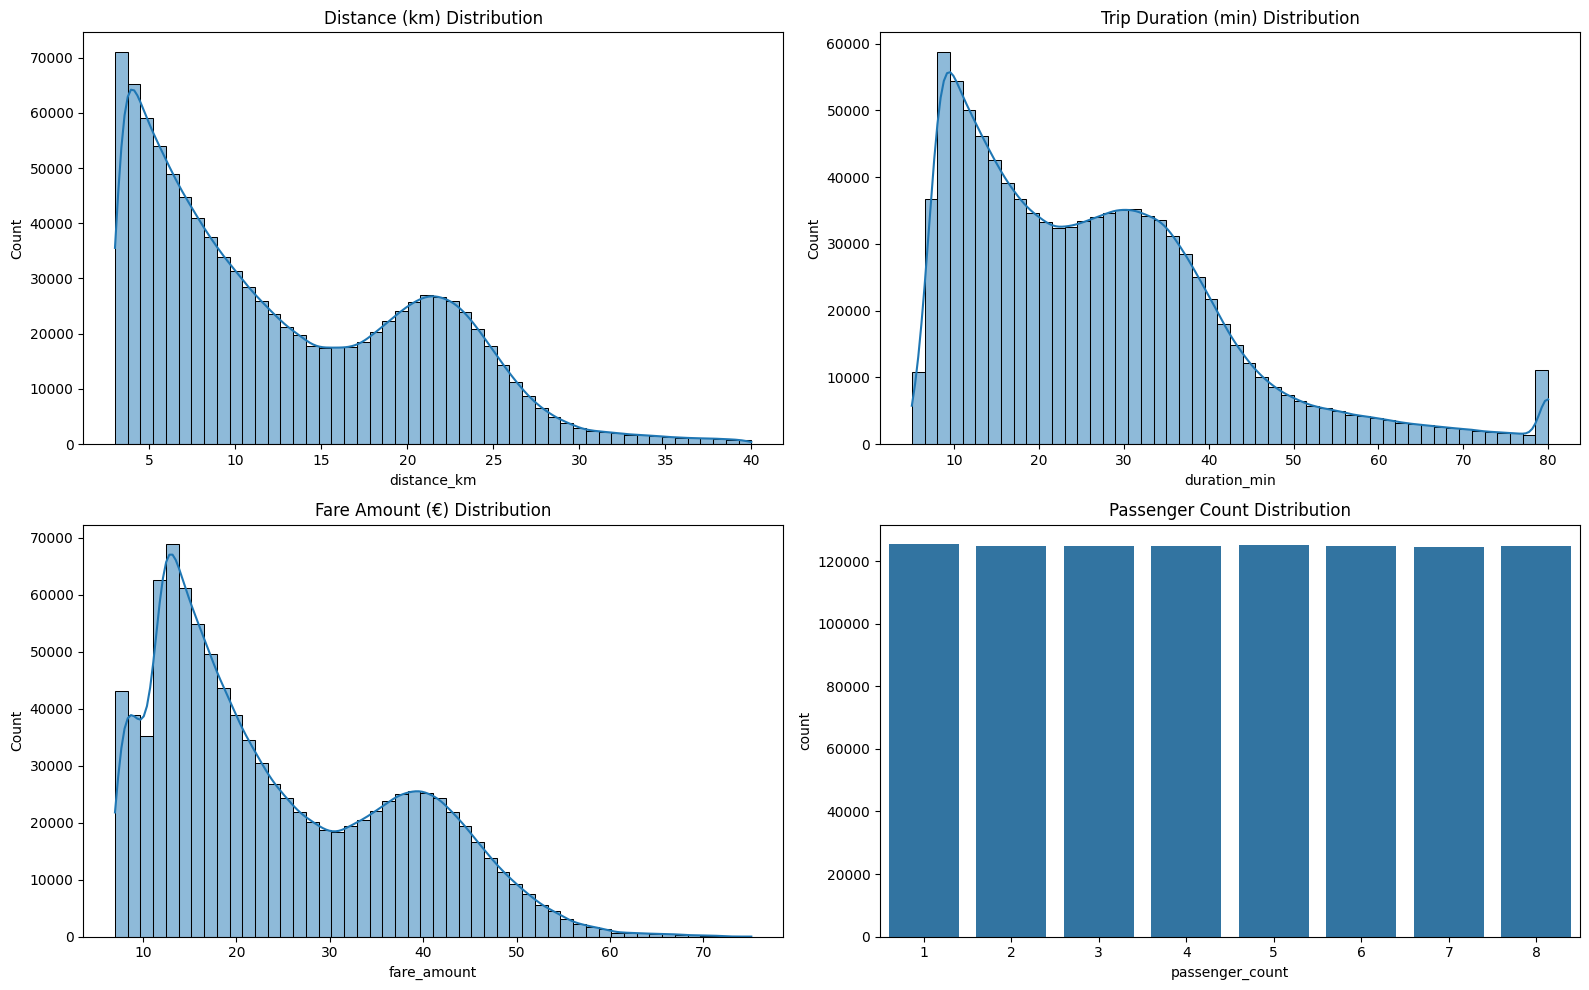

In [129]:
plt.figure(figsize=(16, 10))

# Distance
plt.subplot(2, 2, 1)
sns.histplot(df["distance_km"], bins=50, kde=True)
plt.title("Distance (km) Distribution")

# Duration
plt.subplot(2, 2, 2)
sns.histplot(df["duration_min"], bins=50, kde=True)
plt.title("Trip Duration (min) Distribution")

# Fare
plt.subplot(2, 2, 3)
sns.histplot(df["fare_amount"], bins=50, kde=True)
plt.title("Fare Amount (€) Distribution")

# Passenger count (categorical)
plt.subplot(2, 2, 4)
sns.countplot(x="passenger_count", data=df)
plt.title("Passenger Count Distribution")

plt.tight_layout()
plt.show()


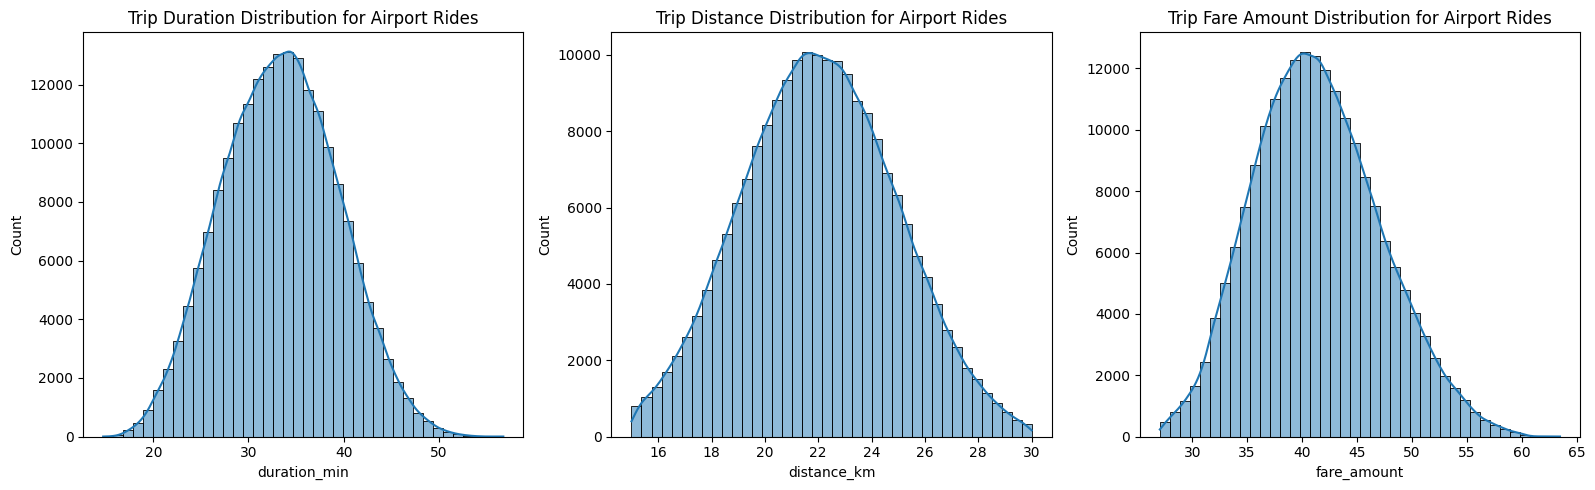

In [130]:
# Filter for airport rides
airport_rides = df[df["is_airport_ride"] == True]

# Summary of their durations and distances
airport_duration_stats = airport_rides["duration_min"].describe()
airport_distance_stats = airport_rides["distance_km"].describe()
airport_price_stats = airport_rides["fare_amount"].describe()


# Plot
plt.figure(figsize=(16, 5))

# Duration
plt.subplot(1, 3, 1)
sns.histplot(airport_rides["duration_min"], bins=40, kde=True)
plt.title("Trip Duration Distribution for Airport Rides")

# Distance
plt.subplot(1, 3, 2)
sns.histplot(airport_rides["distance_km"], bins=40, kde=True)
plt.title("Trip Distance Distribution for Airport Rides")

# Price
plt.subplot(1, 3, 3)
sns.histplot(airport_rides["fare_amount"], bins=40, kde=True)
plt.title("Trip Fare Amount Distribution for Airport Rides")

plt.tight_layout()
plt.show()

In [131]:
airport_duration_stats

count    200526.000000
mean         33.384006
std           6.074061
min          14.738498
25%          29.027290
50%          33.369274
75%          37.624018
max          56.759804
Name: duration_min, dtype: float64

In [132]:
airport_distance_stats

count    200526.000000
mean         22.045747
std           2.864572
min          15.000261
25%          20.026837
50%          22.016110
75%          24.032945
max          29.999664
Name: distance_km, dtype: float64

In [133]:
airport_price_stats

count    200526.000000
mean         41.383084
std           5.757355
min          27.050000
25%          37.250000
50%          41.050000
75%          45.190000
max          63.470000
Name: fare_amount, dtype: float64

In [136]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

# Drop datetime columns if not needed for modeling
df_ml = df.drop(columns=["pickup_datetime", "dropoff_datetime", "traffic_noise"])

train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)

# Save to CSV files
train_df.to_csv("ml-model/train.csv", index=False)
test_df.to_csv("ml-model/test.csv", index=False)

print("Training and testing data saved as 'train.csv' and 'test.csv'")


Training and testing data saved as 'train.csv' and 'test.csv'
